In [1]:
import numpy as np
import nengo
import nengo_spa as spa
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
"""
From Brent's SSP repository: 
"""
def make_good_unitary(D, eps=1e-3, rng=np.random):
    a = rng.rand((D - 1) // 2)
    sign = rng.choice((-1, +1), len(a))
    phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    assert np.all(np.abs(phi) >= np.pi * eps)
    assert np.all(np.abs(phi) <= np.pi * (1 - eps))

    fv = np.zeros(D, dtype='complex64')
    fv[0] = 1
    fv[1:(D + 1) // 2] = np.cos(phi) + 1j * np.sin(phi)
    fv[-1:D // 2:-1] = np.conj(fv[1:(D + 1) // 2])
    if D % 2 == 0:
        fv[D // 2] = 1

    assert np.allclose(np.abs(fv), 1)
    v = np.fft.ifft(fv)
    # assert np.allclose(v.imag, 0, atol=1e-5)
    v = v.real
    assert np.allclose(np.fft.fft(v), fv)
    assert np.allclose(np.linalg.norm(v), 1)
    return spa.SemanticPointer(v)

## Decoding convolutive exponents from semantic pointers

In [3]:
D = 512

X = make_good_unitary(D)
Y = make_good_unitary(D)

xs = np.linspace(-6, 6, 100)
ys = np.linspace(-6, 6, 100)

## 1-D case

Here we simulate retrieving the exponent `k` given that we know the encoded SSP (elements there of are `n`s in the loop below) and the axis SSP. There is also an assumption on ranges of some values (e.g, the integer `j` for the cosine), which might not work for all cases.

In [4]:
import utils
import numpy as np

js = np.array([-1, 0, 1])   # cos(x) = cos(x + 2*pi*j), j \in Z 
                            #     -> this range is an assumption, this is just a subset in Z
k = -1.5                    # convolutive exponent value (or coordinate in 1D spatial domain)
d = 512                     # dimensionality of the SSP
X = make_good_unitary(d)    # X is axis SP
fx = np.fft.fft(X.v)        #  Fourier coefficients
phi = np.angle(fx)          #  Angles associated with each coefficient

exps = []   # list of exponent candidates

print('Total elements,', len(fx)//2-1)
for idx in range(1, len(fx)//2):  # iterating over individual Fourier coefficients
    n = fx[idx]**k                # in reality, we will only know (n) (we don't know k)
    exp_candidate = (np.angle(n) - 2*np.pi*js)/phi[idx]  # these are possible k's 
                                                         #  --> all valid because of periodic function
    exps.extend(exp_candidate.tolist())            

ar = sorted(exps)[5:-5]  # WIP: get rid of extreme values/figure out where they come from
a, b = np.histogram(ar, bins=np.unique(ar))        # find which k occurs most often
print('Estimated exponents: {:.5f} (True: {:.5f})'.format(b[np.argmax(a)], k))

Total elements, 255
Estimated exponents: -1.50000 (True: -1.50000)


The position where every horizontal line and every cosine curve of the same colour cross is a solution for that Fourier coefficient. We are interested in those locations on x-axis where all of those lines cros their corresponding curves (that's our candidate exponent). There infinitely many such crossings (I assume, since the function is periodic), so I make an assumption that we can find the right one if we know the range.

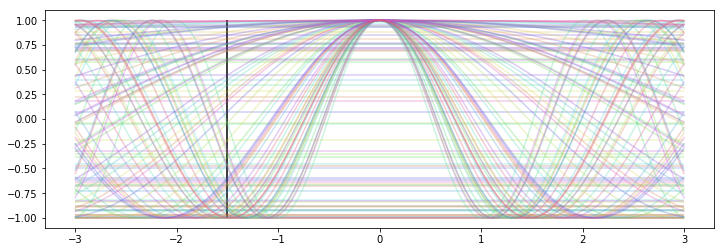

In [5]:
plt.figure(figsize=(12, 4))
xrange = np.linspace(-3, 3, 500)

nr_elements = len(fx)//8
cp = sns.color_palette('hls', n_colors=nr_elements)

for _ in range(1, nr_elements):
    plt.plot(xrange, np.cos(phi[_]*xrange), alpha=.3, color=cp[_-1])
    plt.hlines((fx[_]**k).real, xrange[0], xrange[-1], alpha=.3, color=cp[_-1])

#plt.plot(xrange, np.cos(phi[idx-1]*xrange), color='r')
#plt.hlines(np.cos(np.angle(fx[idx-1]**k)), xrange[0], xrange[-1], color='r')


#plt.plot(xrange, np.cos(phi[idx-4]*xrange), color='b')
#plt.hlines(np.cos(np.angle(fx[idx-4]**k)), xrange[0], xrange[-1], color='b')

plt.vlines(k, -1, 1)
plt.show()

## 2D case

The story is similar for the 2D case except that we need to retrieve a pair of coefficients `(k1, k2)` and this time we need to solve a linear system of equations to get potential candidates:

In [11]:
gamma = np.angle(np.fft.fft(X.v))
phi = np.angle(np.fft.fft(Y.v))

valid_exponents = []

x = 3.14159
y = 2.71828

vec_exp = np.fft.ifft(np.fft.fft(X.v)**x * np.fft.fft(Y.v)**y).real
vec_r = np.fft.fft(vec_exp)
alpha = np.angle(vec_r)
#exponents = np.sign(n.imag)*(np.arccos(n.real)+2*np.pi*exps)/(phi[idx]+gamma[idx])
#valid_exponents.extend(exponents.tolist())
#exponents = (np.log(vec_r) / (1j*(phi+gamma))).real

In [12]:
js = np.arange(-6, 7) #[-1, 0, 1]

eps = 0.001
decimals = 5

found = []
valid_exp_pairs = []

for idx1 in np.arange(1, len(vec_r)//2-1):
    idx2 = idx1 + 1
    for j1 in js:
        for j2 in js:
            a = [gamma[idx1], phi[idx1]]
            b = [gamma[idx2], phi[idx2]]
            c = [alpha[idx1] + 2*np.pi*j1, alpha[idx2] + 2*np.pi*j2]
            k1, k2 = np.linalg.solve([a,b], c)
            valid_exp_pairs.append((np.round(k1, decimals=decimals), np.round(k2, decimals=decimals)))
            
            s_toprint = "{}, {} -- {:.2f}\t{:.2f}"
            if np.abs(k1-x) < eps and np.abs(k2-y) < eps:
                found.extend([j1, j2])

Find the most common (k1, k2) pair:

In [13]:
from collections import defaultdict

In [14]:
d = defaultdict(int)
for pair in valid_exp_pairs:
    d[pair] += 1

In [15]:
unique_keys = list(d.keys())
counts = list(d.values())

print('Estimaated coordinates:', unique_keys[np.argmax(counts)])
print('True coordinates:', x, y)

Estimaated coordinates: (3.14159, 2.71828)
True coordinates: 3.14159 2.71828
